# Pyrenew demo
This demo simulates some basic renewal process data and then fits to it using `pyrenew`.

You'll need to install `pyrenew` first. You'll also need working installations of `matplotlib`, `numpy`, `jax`, `numpyro`, and `polars`

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.size"] = 10
mpl.rcParams["axes.formatter.use_mathtext"] = True
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams["legend.fancybox"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 1

import jax
import jax.numpy as jnp
import numpy as np
from numpyro.handlers import seed
import numpyro.distributions as dist

/home/xrd4/.cache/pypoetry/virtualenvs/pyrenew-e8bt3r2y-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


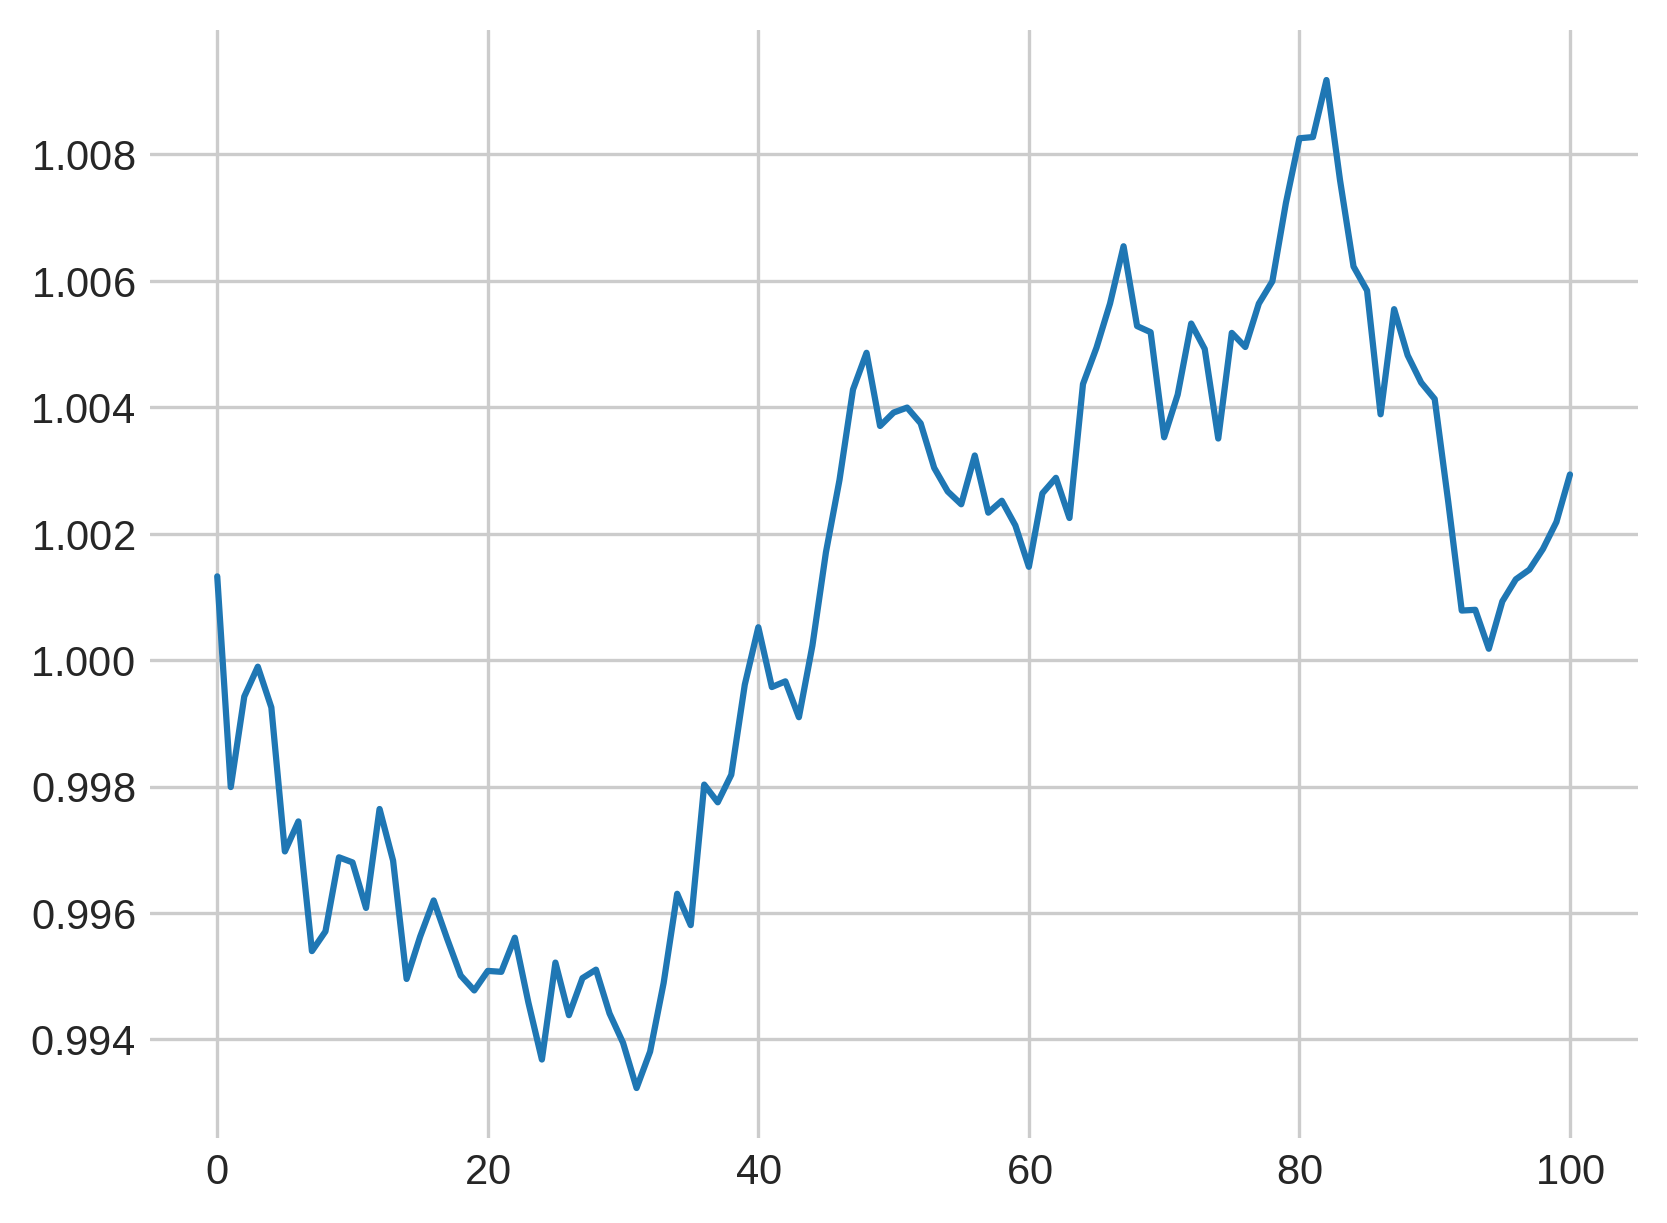

In [2]:
from pyrenew.processes import SimpleRandomWalkProcess

q = SimpleRandomWalkProcess(dist.Normal(0, 0.001))
with seed(rng_seed=np.random.randint(0,1000)):
    q_samp = q.sample(duration=100)
    
plt.plot(np.exp(q_samp))

In [3]:
from pyrenew.observations import (
    InfectionsObservation,
    HospitalizationsObservation,
    PoissonObservation
)

from pyrenew.models import HospitalizationsModel
from pyrenew.processes import RtRandomWalkProcess

# Initializing model parameters
infections_obs = InfectionsObservation(jnp.array([0.25, 0.25, 0.25, 0.25]))
Rt_process = RtRandomWalkProcess()
hosp_obs = HospitalizationsObservation(
    inf_hosp_int=jnp.array(
        [0, 0, 0,0,0,0,0,0,0,0,0,0,0, 0.25, 0.5, 0.1, 0.1, 0.05],
        ),
    infections_obs_varname='infections',
    hosp_dist=PoissonObservation(
        rate_varname='hospitalizations_predicted',
        counts_varname='hospitalizations_obs',
        )
)

# Initializing the model
hospmodel = HospitalizationsModel(
    Rt_process     = Rt_process,
    infections_obs = infections_obs,
    hosp_obs       = hosp_obs
    )

In [4]:
with seed(rng_seed=np.random.randint(1, 60)):
    x = hospmodel.model(constants=dict(n_timepoints=30))
x

HospSample(Rt=Array([1.4147593, 1.4386755, 1.4192305, 1.4363266, 1.4715171, 1.4678109,
       1.4910731, 1.4101087, 1.3773592, 1.3563529, 1.3597177, 1.3322048,
       1.3581408, 1.4206011, 1.4128112, 1.4106929, 1.4344068, 1.4095563,
       1.4437616, 1.4687145, 1.4614947, 1.4257109, 1.4308189, 1.4145304,
       1.4745824, 1.4924589, 1.4958425, 1.4796048, 1.4818647, 1.4758334,
       1.4380898], dtype=float32), infect_sampled=Array([  2.7049415,   3.7235513,   4.994368 ,   6.8479166,   6.721441 ,
         8.178377 ,   9.968608 ,  11.180873 ,  12.413209 ,  14.153904 ,
        16.220274 ,  17.974195 ,  20.630695 ,  24.497934 ,  28.01714  ,
        32.135574 ,  37.754066 ,  43.134083 ,  50.907345 ,  60.191986 ,
        70.14717  ,  79.975464 ,  93.44034  , 107.41765  , 129.38747  ,
       153.05946  , 180.73701  , 211.06621  , 249.78688  , 293.1926   ,
       336.07538  ], dtype=float32), IHR=Array(0.04523885, dtype=float32), pred_hosps=Array([0.        , 0.        , 0.        , 0.        

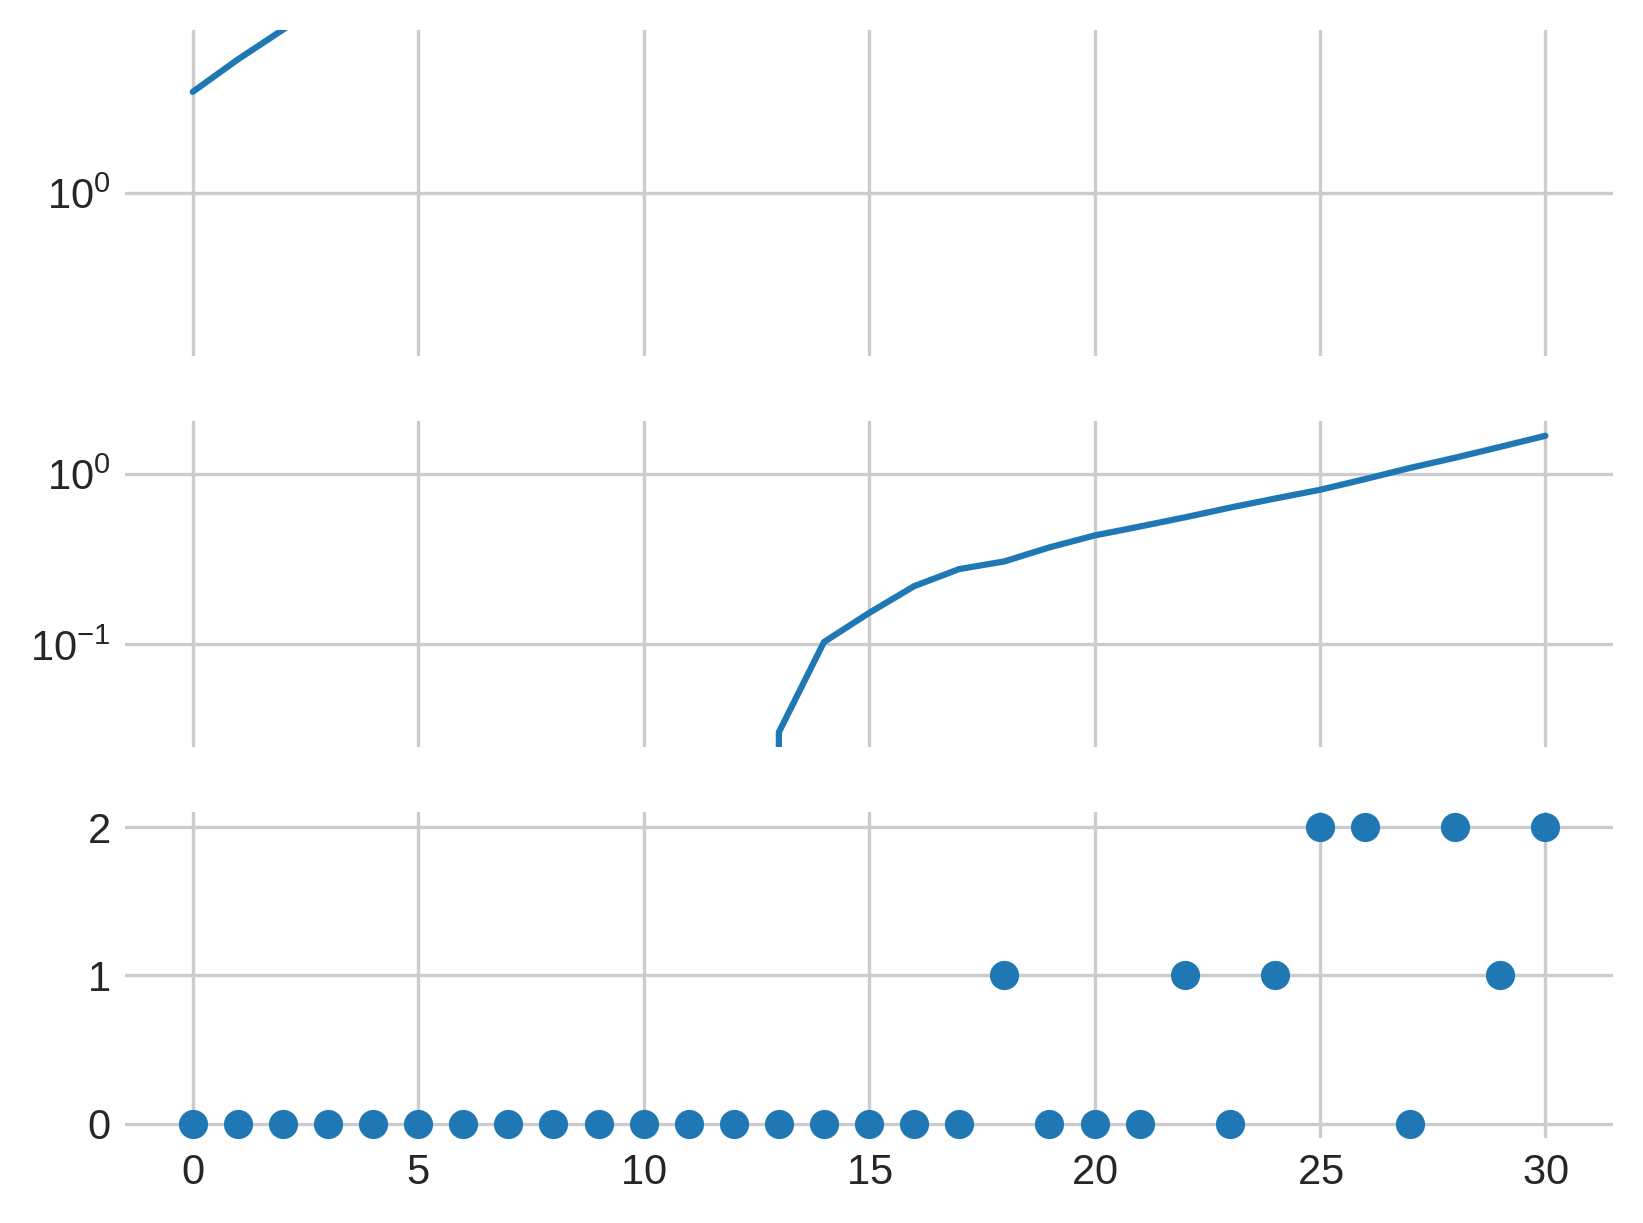

In [5]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(x.infect_sampled)
ax[0].set_ylim([1/5, 5])
ax[1].plot(x.pred_hosps)
ax[2].plot(x.samp_hosp, 'o')
for axis in ax[:-1]:
    axis.set_yscale("log")

In [6]:
sim_dat={"hospitalizations_obs": x.samp_hosp}
constants = {"n_timepoints":len(x.samp_hosp)-1}

# from numpyro.infer import MCMC, NUTS
hospmodel.run(
    num_warmup=1000,
    num_samples=1000,
    random_variables=sim_dat,
    constants=constants,
    rng_key=jax.random.PRNGKey(54),
    )

sample: 100%|██████████| 2000/2000 [00:02<00:00, 952.80it/s, 7 steps of size 4.68e-01. acc. prob=0.88] 


In [7]:
hospmodel.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                         I0      7.73      1.89      7.45      5.10     10.72    969.52      1.00
                        IHR      0.05      0.00      0.05      0.05      0.05   1977.79      1.00
                        Rt0      1.37      0.10      1.37      1.20      1.54    729.01      1.00
 Rt_transformed_rw_diffs[0]      0.00      0.02      0.00     -0.03      0.04   1094.73      1.00
 Rt_transformed_rw_diffs[1]      0.00      0.03      0.00     -0.04      0.04   1510.64      1.00
 Rt_transformed_rw_diffs[2]      0.00      0.03      0.00     -0.04      0.04   1275.28      1.00
 Rt_transformed_rw_diffs[3]      0.00      0.02      0.00     -0.04      0.04   1754.70      1.00
 Rt_transformed_rw_diffs[4]      0.00      0.02      0.00     -0.03      0.04   1282.99      1.00
 Rt_transformed_rw_diffs[5]      0.00      0.03      0.00     -0.04      0.04   1537.35      1.00
 Rt_transformed_rw_

In [8]:
from pyrenew.mcmcutils import spread_draws
samps = spread_draws(hospmodel.mcmc.get_samples(), [("Rt", "time")])

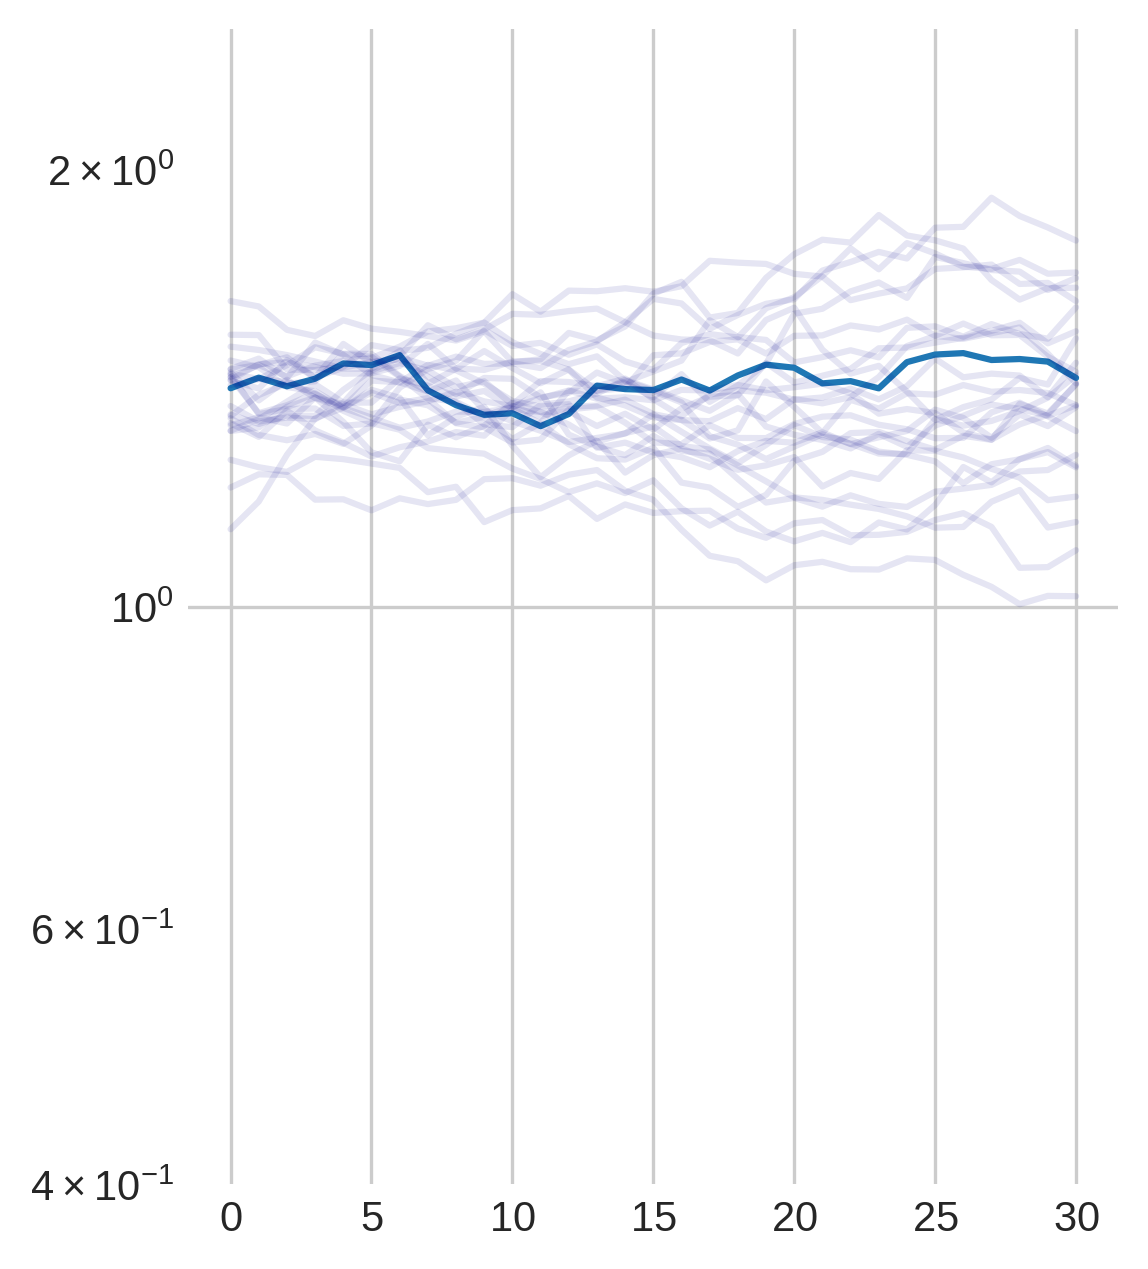

In [9]:
import numpy as np
import polars as pl
fig, ax = plt.subplots(figsize=[4, 5])

ax.plot(x[0])
samp_ids = np.random.randint(size=25, low=0, high=999)
for samp_id in samp_ids:
    sub_samps = samps.filter(pl.col("draw") == samp_id).sort(pl.col('time'))
    ax.plot(sub_samps.select("time").to_numpy(), 
            sub_samps.select("Rt").to_numpy(), color="darkblue", alpha=0.1)
ax.set_ylim([0.4, 1/.4])
ax.set_yticks([0.5, 1, 2])
ax.set_yscale("log")
